In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    RocCurveDisplay, 
    ConfusionMatrixDisplay, 
    PrecisionRecallDisplay
)
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    confusion_matrix, 
    precision_recall_curve, 
    roc_curve
)
from imblearn.under_sampling import TomekLinks
from sklearn.neighbors import NearestNeighbors
import random
from storage_model import save_model, load_model


# HYPER-PARAMETERS

In [3]:
TEST_SIZE = 0.2
N_SPLITS = 5
REGRESSION_C = 10
PART_NEIGHBOARDS = 0.3
POSITIVE_SCALE = 3
RANDOM_STATE = 341

param_grid = [
    {
        'C': [50],
        'penalty': ['l2'],
        'solver': ['sag']
    },


]

# Optimization

In [4]:
def reduce_mem_usage(df : pd.DataFrame):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == 'float':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo('f2').min and c_max < np.finfo('f2').max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo('f4').min and c_max < np.finfo('f4').max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type)[:3] == 'int':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo('i1').min and c_max < np.iinfo('i1').max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo('i2').min and c_max < np.iinfo('i2').max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo('i4').min and c_max < np.iinfo('i4').max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo('i8').min and c_max < np.iinfo('i8').max:
                df[col] = df[col].astype(np.int64)
        elif str(col_type)[:8] == 'datetime':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Потребление памяти меньше на',
         round(start_mem - end_mem, 2),
         'Мб (минус',
         round(100 * (start_mem - end_mem) / start_mem, 1),
         '%)')
    return df

# Data extract

In [5]:
methods = {
    "SHG Intensity" : [
        "SHG Intensity Mean",
        "SHG Intensity MAD",
        "SHG Intensity Contrast",
        "SHG Intensity Correlation",
        "SHG Intensity Entropy",
        "SHG Intensity ASM",
        "SHG Intensity IDM"
    ],
    "R-Ratio" : [
        "R-Ratio Mean",
        "R-Ratio MAD",
        "R-Ratio Contrast",
        "R-Ratio Correlation",
        "R-Ratio Entropy",
        "R-Ratio ASM"
    ],
    "Degree of Circular Polarization" : [
        "Degree of Circular Polarization Mean",
        "Degree of Circular Polarization MAD",
        "Degree of Circular Polarization Contrast",
        "Degree of Circular Polarization Correlation",
        "Degree of Circular Polarization Entropy",
        "Degree of Circular Polarization ASM",
        "Degree of Circular Polarization IDM"
    ],
    "SHG-CD" : [ 
        "SHG-CD MAD",
        "SHG-CD Contrast",
        "SHG-CD Correlation",
        "SHG-CD Entropy",
        "SHG-CD ASM",
        "SHG-CD IDM"
    ],
    "SHG-LD" : [
        "SHG-LD MAD",
        "SHG-LD Contrast",
        "SHG-LD Correlation",
        "SHG-LD Entropy",
        "SHG-LD ASM",
        "SHG-LD IDM"
    ],
    "Params" : [
        "2-Group Tag",
        "Pixel Density",
    ]
}

x_axis = sum([methods[key] for key in methods.keys() if key != "Params"], [])
y_axis = methods["Params"][0]
def getData(table_number):
    data = pd.read_excel(io="../../Data/41598_2022_13623_MOESM3_ESM.xlsx", 
    sheet_name=f"{1 << 2 * (table_number - 1)} Subimage Training")
    data = reduce_mem_usage(data)

    data["2-Group Tag"] = data[y_axis] == 2
    return data


# Get predict

In [6]:
estimator = ...
def getModel(X, y):
    global estimator

    estimator = LogisticRegression(
        max_iter=40000, 
        class_weight='balanced',
        random_state=RANDOM_STATE
    )

    return GridSearchCV(estimator, param_grid, scoring='f1_weighted', verbose=2).fit(X, y)
    # return estimator.fit(X, y)


    

In [7]:
def getPredict(model, X):
    y = model.predict(X)
    return y

# Model quality assessment

In [8]:
def modelQualityAssessment(model, X_test, y_test):
    y_predict = getPredict(model, X_test)

    print(f'Accuracy score: %0.2f' % accuracy_score(y_test, y_predict, normalize=True))
    print(f'F1 score: %0.2f' % f1_score(y_test, y_predict, average='weighted'))
    print(f'Precision score: %0.2f' % precision_score(y_test, y_predict, average='weighted'))
    print(f'Recall score: %0.2f' % recall_score(y_test, y_predict, average='weighted'))
    print(f'ROC AUC score: %0.2f' % roc_auc_score(y_test, y_predict, average='weighted'))


    ax = plt.gca()
    svc_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax) #?
    rfc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax) #?
    plt.show()

    cm = confusion_matrix(y_test, y_predict)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()

# Calculate model

In [9]:
def MyTomeLinks(X, y):
    nbrsPositive = NearestNeighbors(n_neighbors=1).fit(X[y == True])
    nbrsNegative = NearestNeighbors(n_neighbors=1).fit(X[y == False])

    distances_positive, indices_positive = nbrsPositive.kneighbors(X[y == False])

    distances_positive = distances_positive.ravel()
    indices_positive = indices_positive.ravel()
    print(max(distances_positive))
    indices_nearest_positive = np.unique(indices_positive[distances_positive < PART_NEIGHBOARDS * max(distances_positive)])

    distances_false, indices_false = nbrsPositive.kneighbors(X[y == True].iloc[indices_nearest_positive])

    indices_nearest_negative = np.unique(indices_false)
    indices_further_positive = np.unique(indices_positive[distances_positive > PART_NEIGHBOARDS * max(distances_positive)])


    X_further_positive = X[y == True].iloc[indices_further_positive]
    X_nearest_positive = X[y == True].iloc[indices_nearest_positive]
    X_nearest_negative = X[y == False].iloc[indices_nearest_negative]


    y_further_positive = y[y == True].iloc[indices_further_positive]
    y_nearest_positive = y[y == True].iloc[indices_nearest_positive]
    y_nearest_negative = y[y == False].iloc[indices_nearest_negative]

    indices_further_negative = np.array(random.sample(tuple(X[y == False].index), min(POSITIVE_SCALE * len(X_further_positive), len(X[y == False].index))))

    X_further_negative = X[y == False].loc[indices_further_negative]
    y_further_negative = y[y == False].loc[indices_further_negative]

    X = pd.concat([X_further_positive, X_nearest_positive, X_nearest_negative, X_further_negative], ignore_index=False)
    y = pd.concat([y_further_positive, y_nearest_positive, y_nearest_negative, y_further_negative], ignore_index=False)

    return X, y

In [10]:
data = getData(5)
X = data[x_axis]
y = data[y_axis]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

Потребление памяти меньше на 0.69 Мб (минус 75.4 %)


In [11]:
# X_train, y_train = MyTomeLinks(X_train, y_train)
# X_train, y_train = TomekLinks().fit_resample(X_train, y_train)
print(len(X_train))
model = getModel(X_train, y_train)

2829
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .......................C=50, penalty=l2, solver=sag; total time=   5.9s
[CV] END .......................C=50, penalty=l2, solver=sag; total time=   6.0s
[CV] END .......................C=50, penalty=l2, solver=sag; total time=   5.6s
[CV] END .......................C=50, penalty=l2, solver=sag; total time=   5.8s
[CV] END .......................C=50, penalty=l2, solver=sag; total time=   5.8s


Accuracy score: 0.90
F1 score: 0.90
Precision score: 0.90
Recall score: 0.90
ROC AUC score: 0.90


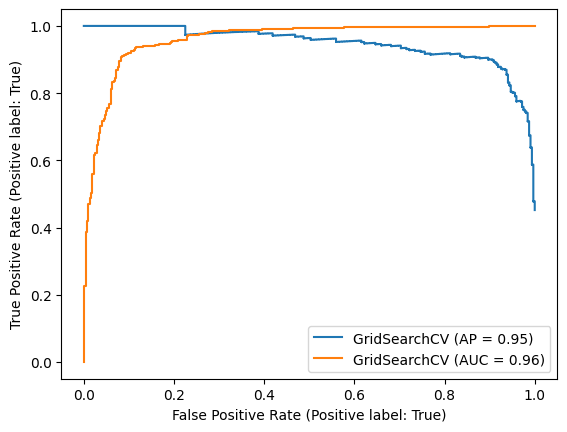

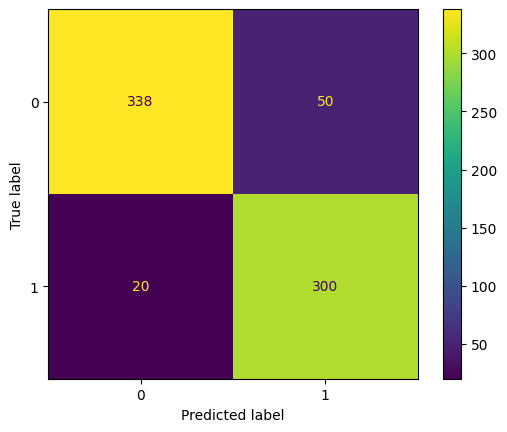

In [12]:
modelQualityAssessment(model, X_test, y_test)

In [13]:
save_model(model, version=None)
model = load_model(0, 0)

Exception: This file doesn't exist

In [ ]:
# cv = ShuffleSplit(n_splits=N_SPLITS, test_size=0.5, random_state=0)
# print("%0.3f" % cross_val_score(model, X_test, y_test, cv=cv, scoring='f1_weighted').mean())
# print("%0.3f" % cross_val_score(model, X_test, y_test, cv=cv, scoring='roc_auc').mean())

In [ ]:
model.best_estimator_

LogisticRegression(C=50, class_weight='balanced', max_iter=40000,
                   random_state=341, solver='sag')